In [19]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt

In [123]:
def camera_calibration():
    objpoints = []
    imgpoints = []
    Cal_images = glob.glob('camera_cal/calibration*.jpg')
    for index, img_name in enumerate(Cal_images):
        # read in image and convert to gray scale
        img  = cv2.imread(img_name)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # find chessboard corner
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        # if corners exists, append object points and image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            name = 'output_images/camera_calibration' + str(index) + '.png'
            cv2.imwrite(name,img)
            if index % 10 == 2:
            # show few sample images
                plt.imshow(img)
                plt.show()
    return objpoints, imgpoints

def image_undistortion(img, objpoints, imgpoints):
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    # return undistorted images
    return dst

def get_transform(img):
    img_size    = (img.shape[1], img.shape[0])
    bot_width   = .76
    mid_width   = .08
    height_pct  = .62
    bottom_trim = .93
    
    # sources pts
    src1 = (img_size[0]*(.5-mid_width/2), img_size[1]*height_pct)
    src2 = (img_size[0]*(.5+mid_width/2), img_size[1]*height_pct)
    src3 = (img_size[0]*(.5-bot_width/2), img_size[1]*bottom_trim)
    src4 = (img_size[0]*(.5+bot_width/2), img_size[1]*bottom_trim)
    src  = np.float32([src1, src2, src3, src4])
    
    # destination pts
    offset = img_size[0]*.35
    dst1   = (offset, 0)
    dst2   = (img_size[0]-offset, 0)
    dst3   = (offset, img_size[1])
    dst4   = (img_size[0]-offset, img_size[1])
    dst    = np.float32([dst1, dst2, dst3, dst4])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    return M, Minv

def bird_eye_view(img, M):
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags = cv2.INTER_LINEAR)
    return warped

def get_color_lanes(img):
    # change image into HSV space
    HSV_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # isolate white and yellow lane using threshold
    yellow_Low  = np.array([0,100,150])
    yellow_High = np.array([40,255,255])
    white_Low   = np.array([20,0,200])
    white_High  = np.array([255,90,255])
    yellow_img  = cv2.inRange(HSV_img, yellow_Low, yellow_High)
    white_img   = cv2.inRange(HSV_img, white_Low, white_High)
    # combine lanes
    out_img     = cv2.bitwise_or(yellow_img, white_img)
    return out_img
    
def abs_sobel_thresh(img, orient = 'x', sobel_kernel = 3, thresh = (0,255)):
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = sobel_kernel))
    norm_sobel = np.uint8(225*abs_sobel/np.max(abs_sobel))
    binary_mask = np.zeros_like(norm_sobel)
    binary_mask[(norm_sobel >= thresh[0]) & (norm_sobel <= thresh[1])] = 1
    return binary_mask

def mag_thresh(img, sobel_kernel = 3, mag_thresh = (0, 255)):
    Sx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    Sy = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    mag_sobel = np.sqrt(Sx**2 + Sy**2)
    norm_mag = np.uint8(255*mag_sobel/np.max(mag_sobel))
    binary_mask = np.zeros_like(norm_mag)
    binary_mask[(norm_mag >= mag_thresh[0]) & (norm_mag <= mag_thresh[1])] = 1
    return binary_mask

def dir_threshold(img, sobel_kernel = 3, thresh = (0, np.pi/2)):
    abs_Sx = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = sobel_kernel))
    abs_Sy = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = sobel_kernel))
    grad_dir = np.arctan2(abs_Sy,abs_Sx)
    binary_mask = np.zeros_like(grad_dir)
    binary_mask[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    return binary_mask

def get_gradient(warped):
    Sx_img = abs_sobel_thresh(warped, orient = 'x', sobel_kernel = 5, thresh = (20,150))
    mag_img = mag_thresh(warped, sobel_kernel = 5, mag_thresh = (50,170))
    dir_img = dir_threshold(warped, sobel_kernel = 5, thresh = (.7, 1))
    combined_grad = np.zeros_like(Sx_img)
    combined_grad[(Sx_img == 1)| ((mag_img == 1) & (dir_img == 1))] = 1
    return combined_grad

def LS_gradient(warped):
    HLS_warped = cv2.cvtColor(warped, cv2.COLOR_RGB2HLS) 
    L_warped = HLS_warped[:,:,1]
    S_warped = HLS_warped[:,:,2]
    L_grad = get_gradient(L_warped)
    S_grad = get_gradient(S_warped)
    LS_grad = cv2.bitwise_or(L_grad, S_grad)
    kernel = np.ones((5,5),np.uint8)
    LS_grad = cv2.erode(LS_grad,kernel,iterations = 1)
    return LS_grad

def comb_grad_color(combined_color, combined_grad):
    combined_binary = np.zeros_like(combined_grad)
    combined_binary[(combined_color >= 0.5) | (combined_grad >= 0.5)] = 1
    return combined_binary  


def histogram_search(img):
    # using histogram of the below half of the image to find the base location of lane
    histogram = np.sum(img[img.shape[0]/2:,:], axis=0)
    out_img = np.dstack((img, img, img))*255
    midpoint = np.int(histogram.shape[0]/2)
    base_outer_margin = 200
    base_inner_margin = 100
    leftx_base = np.argmax(histogram[(midpoint-base_outer_margin):midpoint-base_inner_margin])+(midpoint-base_outer_margin)
    rightx_base = np.argmax(histogram[midpoint+base_inner_margin:(midpoint+base_outer_margin)]) + (midpoint+base_inner_margin) 
    # separate left and right lanes
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    l_left_margin = 40
    l_right_margin = 40
    r_left_margin = 40
    r_right_margin = 40
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    nwindows = 9
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    for window in range(9):
        # Identify first pass of window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - l_left_margin
        win_xleft_high = leftx_current + l_right_margin
        win_xright_low = rightx_current - r_left_margin
        win_xright_high = rightx_current + r_right_margin

        # Identify the nonzero pixels in x and y within the window
        good_left_inds  = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # If you found > minpix pixels, recenter this current window and do the search again
        # if the center moves more than 30 pixal, the window side will increase toward that direction
        # this is to help in situation where there is a shape turn
        if len(good_left_inds) > minpix:
            leftx_previous = leftx_current
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if leftx_current-leftx_previous <= -30:
                l_left_margin = l_left_margin + 20
                l_right_margin = l_right_margin - 20
            if leftx_current-leftx_previous >= 30:
                l_right_margin = l_right_margin + 20
                l_left_margin = l_left_margin - 20
                
        # If you found > minpix pixels, recenter this current window and do the search again
        # if the center moves more than 30 pixal, the window side will increase toward that direction
        # this is to help in situation where there is a shape turn
        if len(good_right_inds) > minpix:
            rightx_previous = rightx_current
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            if rightx_current-rightx_previous <= -30:
                r_left_margin = r_left_margin + 20
                r_right_margin = r_right_margin - 20
            if rightx_current-rightx_previous >= 30:
                r_right_margin = r_right_margin + 20
                r_left_margin = r_left_margin -20
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
    # Extract left and right line pixel positions
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    return leftx, lefty, rightx, righty, out_img, histogram

def next_mask(img, left_fit, right_fit):
    nonzero  = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 40
    left_lane_inds  = ((nonzerox > (left_fit[0]*(nonzeroy**2)+left_fit[1]*nonzeroy+left_fit[2]-margin))&(nonzerox < (left_fit[0]*(nonzeroy**2)+left_fit[1]*nonzeroy+left_fit[2]+margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2)+right_fit[1]*nonzeroy+right_fit[2]-margin))&(nonzerox < (right_fit[0]*(nonzeroy**2)+right_fit[1]*nonzeroy+right_fit[2]+margin)))
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty
    
    
def second_order_fit(x,y):
    line_coef = np.polyfit(y, x, 2)
    return line_coef

def draw_poly_line(img, left_fit, right_fit):
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return ploty, left_fitx, right_fitx

def find_curvature(ploty, x, y):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    fit_cr =  np.polyfit(y*ym_per_pix, x*xm_per_pix, 2)
    # Calculate the new radii of curvature
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    
    # Now our radius of curvature is in meters
    return curverad
    # Example values: 632.1 m    626.2 m
    
def overlay_img(warped, ploty, left_fitx, right_fitx, Minv, img):
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv,(img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return result, newwarp, color_warp



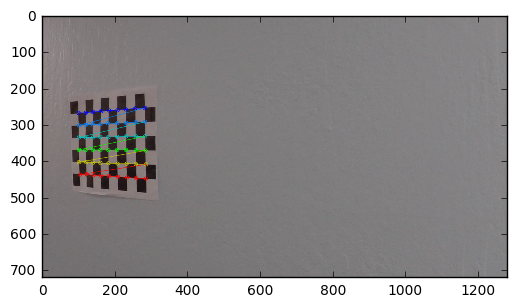

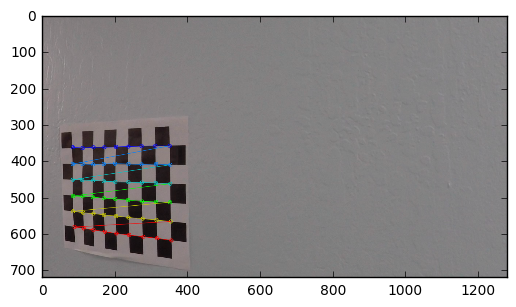

In [95]:
# Perform camera calibration for a chessboard of grid nx = 9, ny = 6
nx = 9
ny = 6
objp = np.zeros((nx*ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
objpoints, imgpoints = camera_calibration() 

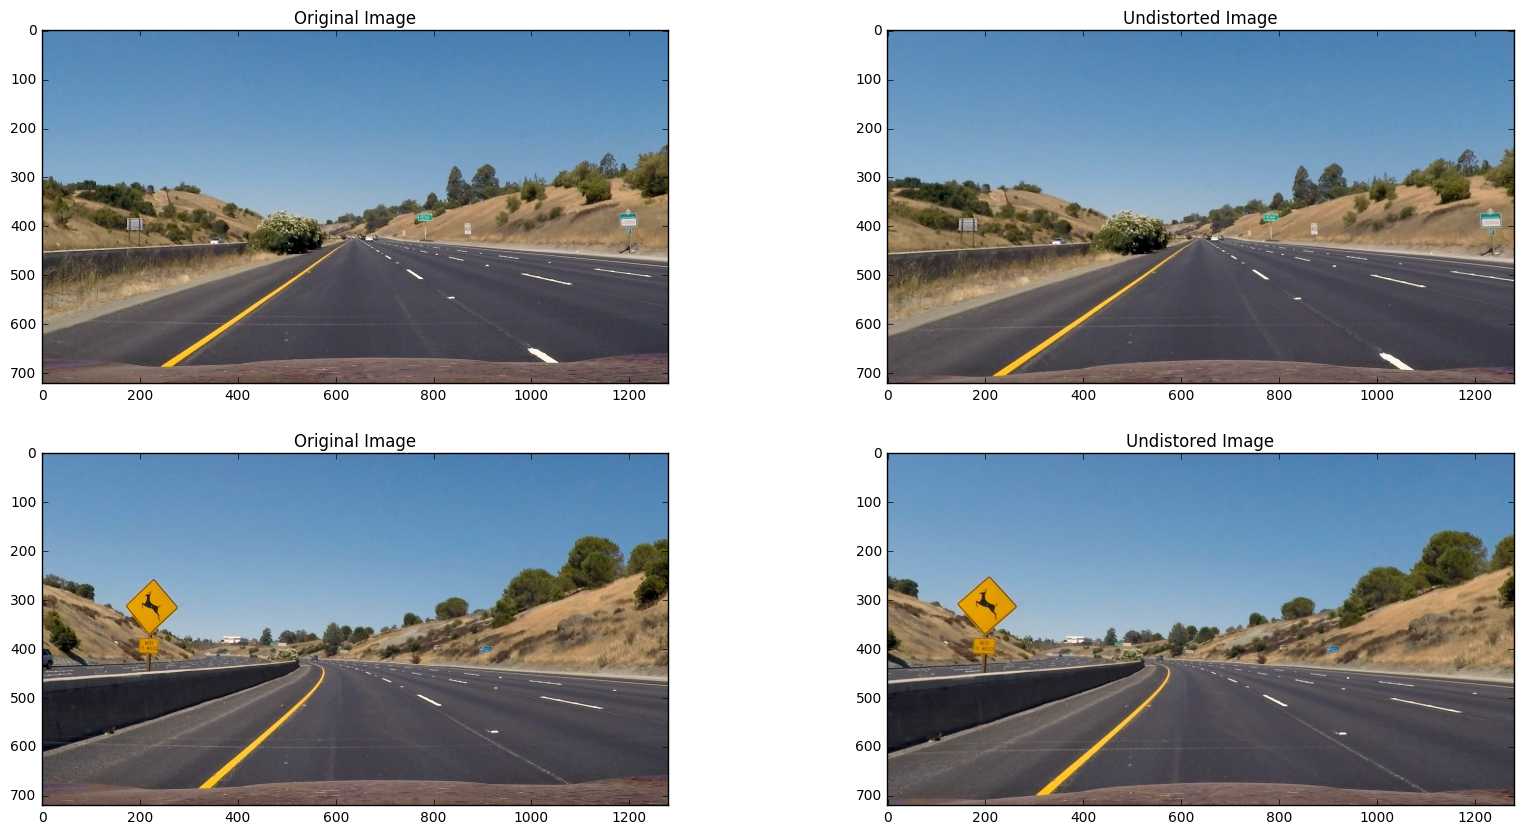

In [31]:
test_img1 = cv2.imread('test_images/straight_lines1.jpg')
test_img1 = cv2.cvtColor(test_img1, cv2.COLOR_BGR2RGB)
undist_img1 = image_undistortion(test_img1, objpoints, imgpoints)
test_img2 = cv2.imread('test_images/test2.jpg')
test_img2 = cv2.cvtColor(test_img2, cv2.COLOR_BGR2RGB)
undist_img2 = image_undistortion(test_img2, objpoints, imgpoints)

plt.figure(figsize = (20,10))
plt.subplot(2,2,1)
plt.title('Original Image')
plt.imshow(test_img1)

plt.subplot(2,2,2)
plt.title('Undistorted Image')
plt.imshow(undist_img1)

plt.subplot(2,2,3)
plt.title('Original Image')
plt.imshow(test_img2)

plt.subplot(2,2,4)
plt.imshow(undist_img2)
plt.title('Undistored Image')
plt.show()

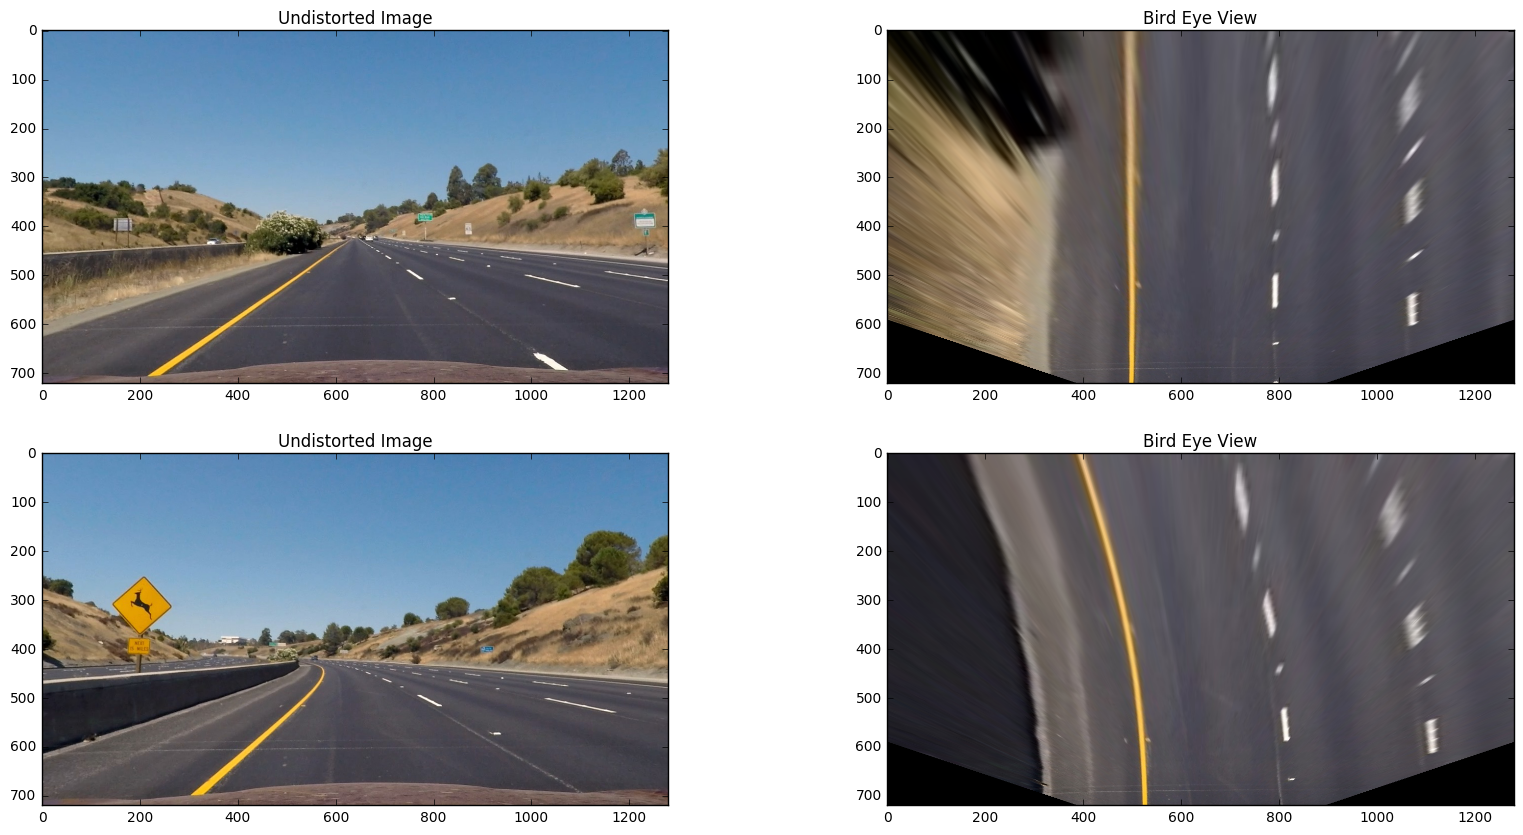

In [39]:
M, Minv = get_transform(undist_img1)
warped1 = bird_eye_view(undist_img1, M)
warped2 = bird_eye_view(undist_img2, M)

plt.figure(figsize = (20,10))
plt.subplot(2,2,1)
plt.title('Undistorted Image')
plt.imshow(undist_img1)

plt.subplot(2,2,2)
plt.title('Bird Eye View')
plt.imshow(warped1)

plt.subplot(2,2,3)
plt.title('Undistorted Image')
plt.imshow(undist_img2)

plt.subplot(2,2,4)
plt.title('Bird Eye View')
plt.imshow(warped2)

plt.show()

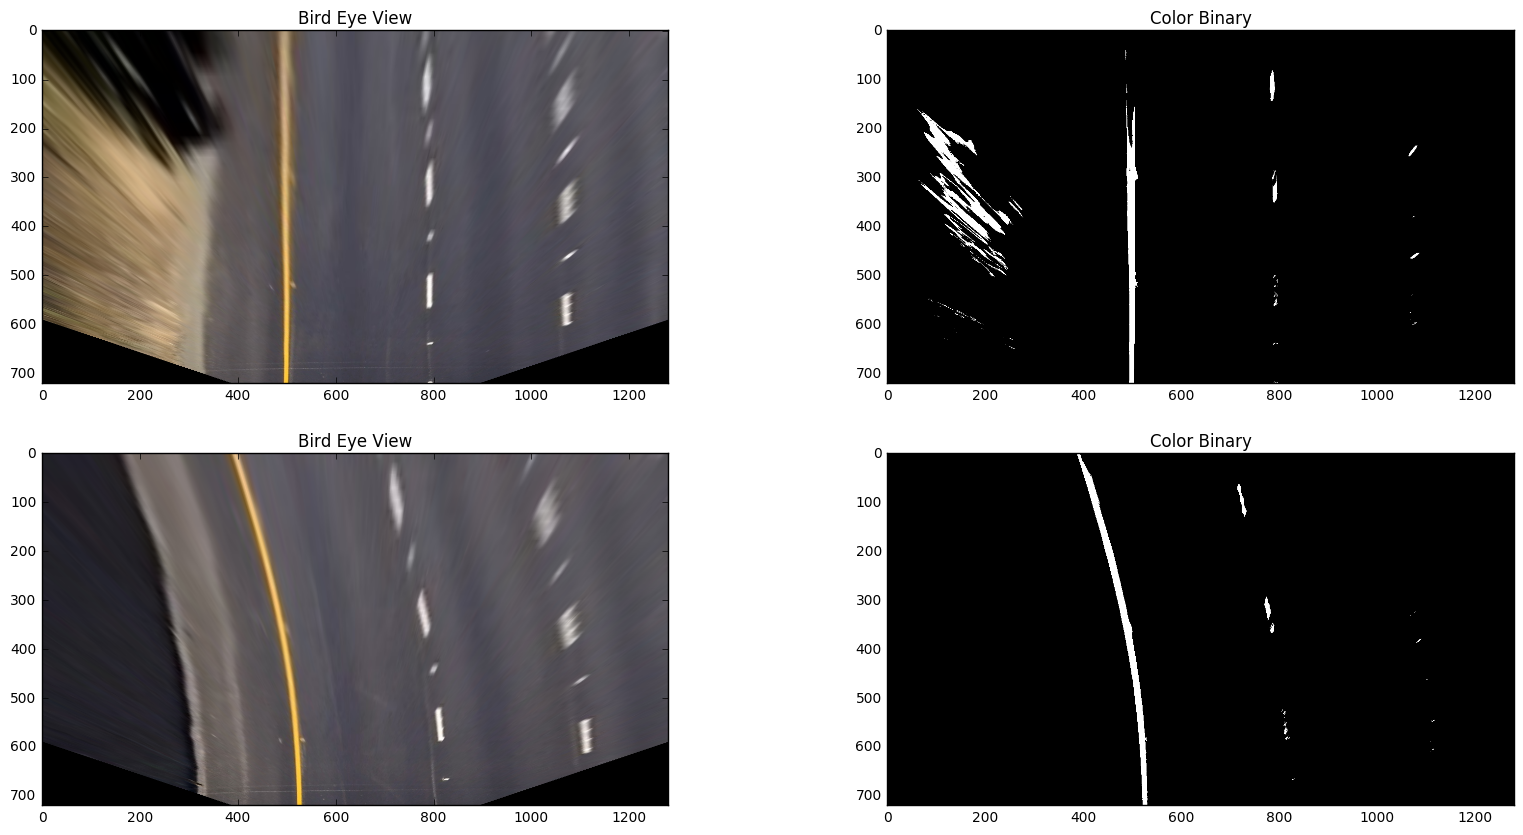

In [56]:
color1 = get_color_lanes(warped1)
color1_binary = np.dstack((color1, color1, color1))
color2 = get_color_lanes(warped2)
color2_binary = np.dstack((color2, color2, color2))

plt.figure(figsize = (20,10))
plt.subplot(2,2,1)
plt.title('Bird Eye View')
plt.imshow(warped1)

plt.subplot(2,2,2)
plt.title('Color Binary')
plt.imshow(color1_binary)

plt.subplot(2,2,3)
plt.title('Bird Eye View')
plt.imshow(warped2)

plt.subplot(2,2,4)
plt.title('Color Binary')
plt.imshow(color2_binary)

plt.show()

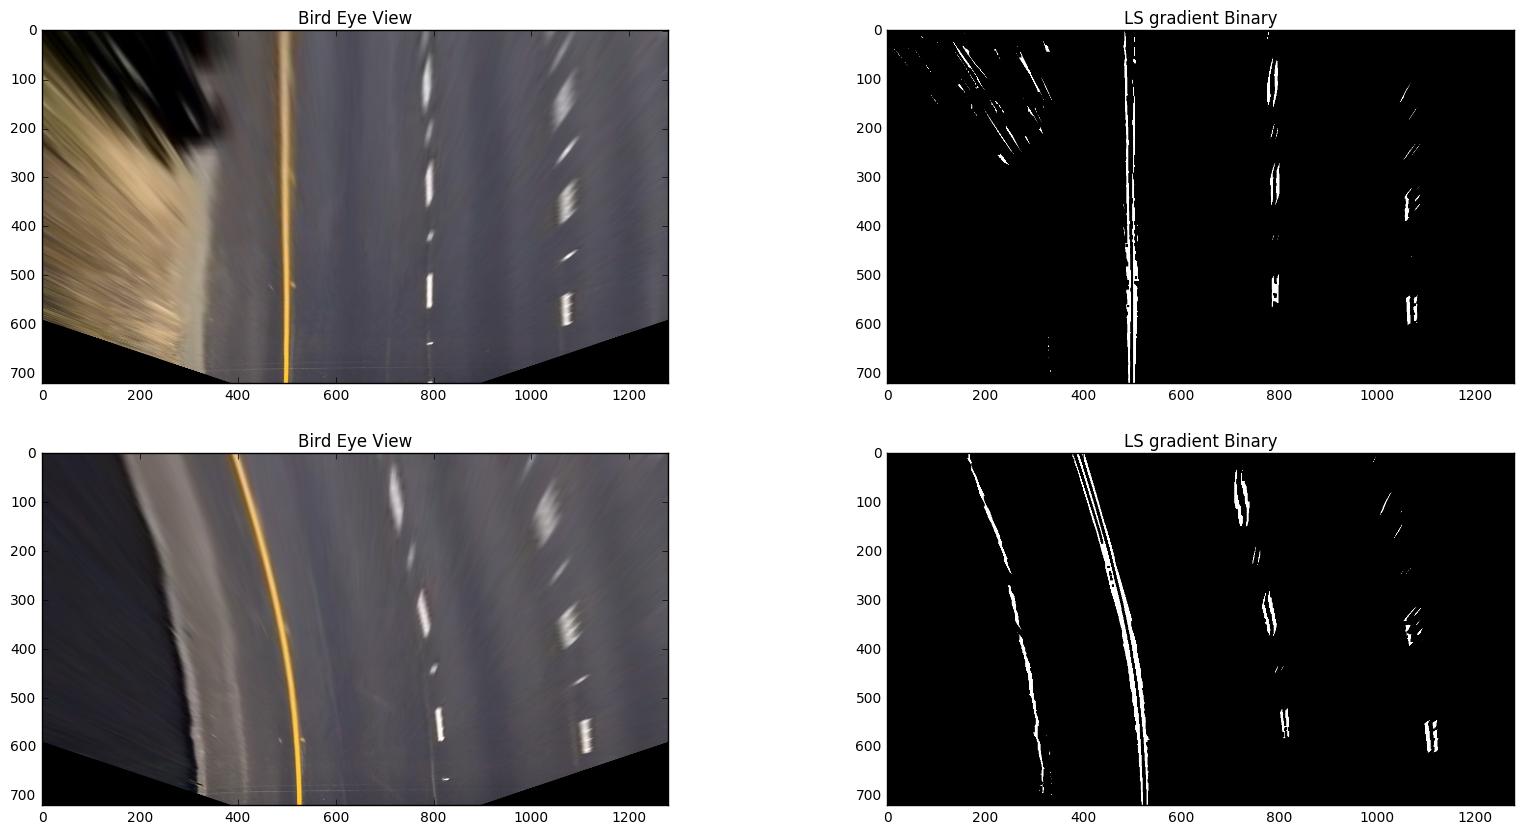

In [62]:
LS1 = LS_gradient(warped1)
LS1_binary = np.dstack((LS1, LS1, LS1))*255
LS2 = LS_gradient(warped2)
LS2_binary = np.dstack((LS2, LS2, LS2))*255

plt.figure(figsize = (20,10))
plt.subplot(2,2,1)
plt.title('Bird Eye View')
plt.imshow(warped1)

plt.subplot(2,2,2)
plt.title('LS gradient Binary')
plt.imshow(LS1_binary)

plt.subplot(2,2,3)
plt.title('Bird Eye View')
plt.imshow(warped2)

plt.subplot(2,2,4)
plt.title('LS gradient Binary')
plt.imshow(LS2_binary)

plt.show()

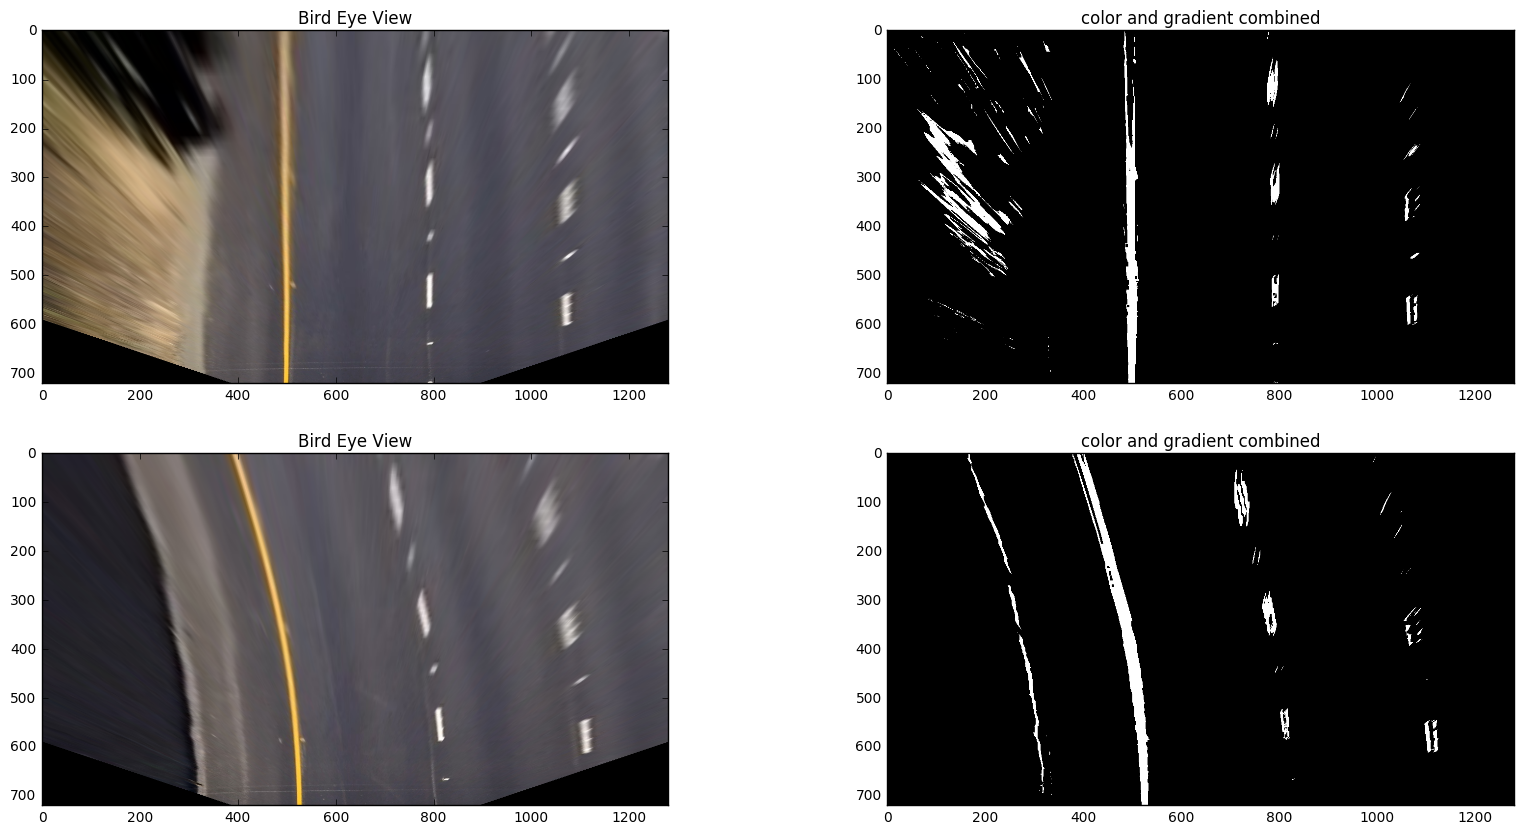

In [66]:
combined_binary1 = comb_grad_color(color1, LS1)
combined_binary1_bw = np.dstack((combined_binary1,combined_binary1,combined_binary1))*255
combined_binary2 = comb_grad_color(color2, LS2)
combined_binary2_bw = np.dstack((combined_binary2,combined_binary2,combined_binary2))*255

plt.figure(figsize = (20,10))
plt.subplot(2,2,1)
plt.title('Bird Eye View')
plt.imshow(warped1)

plt.subplot(2,2,2)
plt.title('color and gradient combined')
plt.imshow(combined_binary1_bw)

plt.subplot(2,2,3)
plt.title('Bird Eye View')
plt.imshow(warped2)

plt.subplot(2,2,4)
plt.title('color and gradient combined')
plt.imshow(combined_binary2_bw)

plt.show()

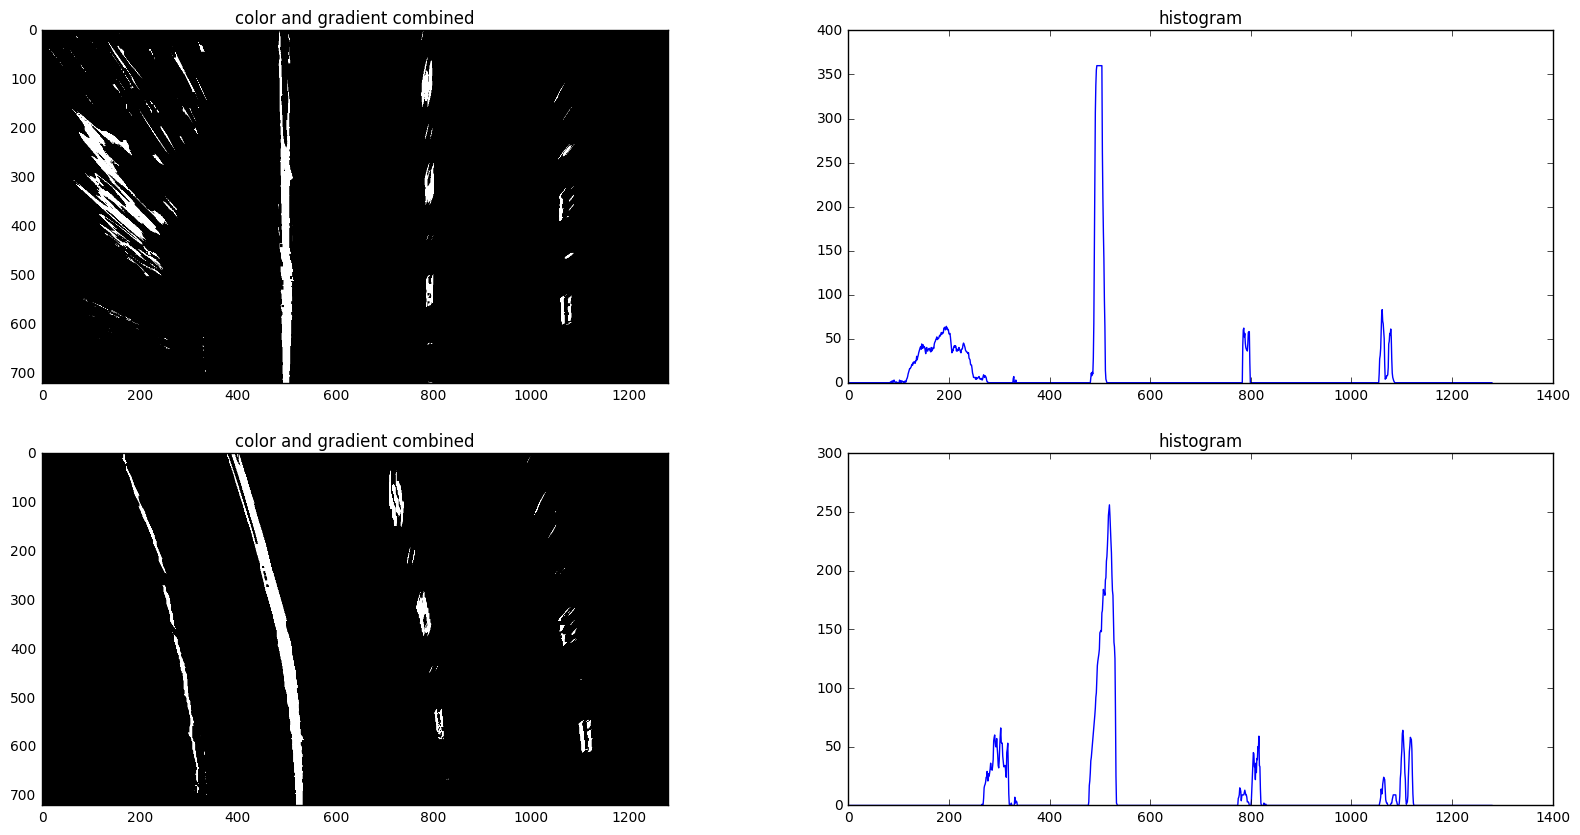

In [82]:
leftx1, lefty1, rightx1, righty1, out_img1, histogram1 = histogram_search(combined_binary1)
leftx2, lefty2, rightx2, righty2, out_img2, histogram2 = histogram_search(combined_binary2)

plt.figure(figsize = (20,10))
plt.subplot(2,2,1)
plt.title('color and gradient combined')
plt.imshow(combined_binary1_bw)


plt.subplot(2,2,2)
plt.title('histogram')
plt.plot(histogram1)

plt.subplot(2,2,3)
plt.title('color and gradient combined')
plt.imshow(combined_binary2_bw)

plt.subplot(2,2,4)
plt.title('histogram')
plt.plot(histogram2)

plt.show()

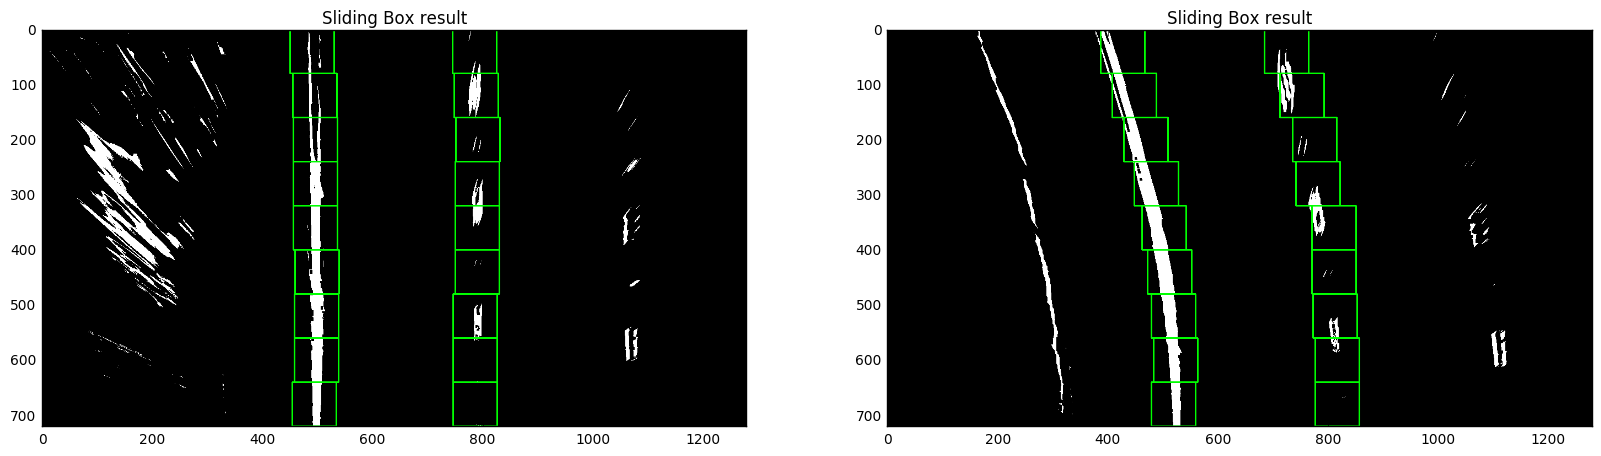

In [83]:
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.title('Sliding Box result')
plt.imshow(out_img1)

plt.subplot(1,2,2)
plt.title('Sliding Box result')
plt.imshow(out_img2)

plt.show()

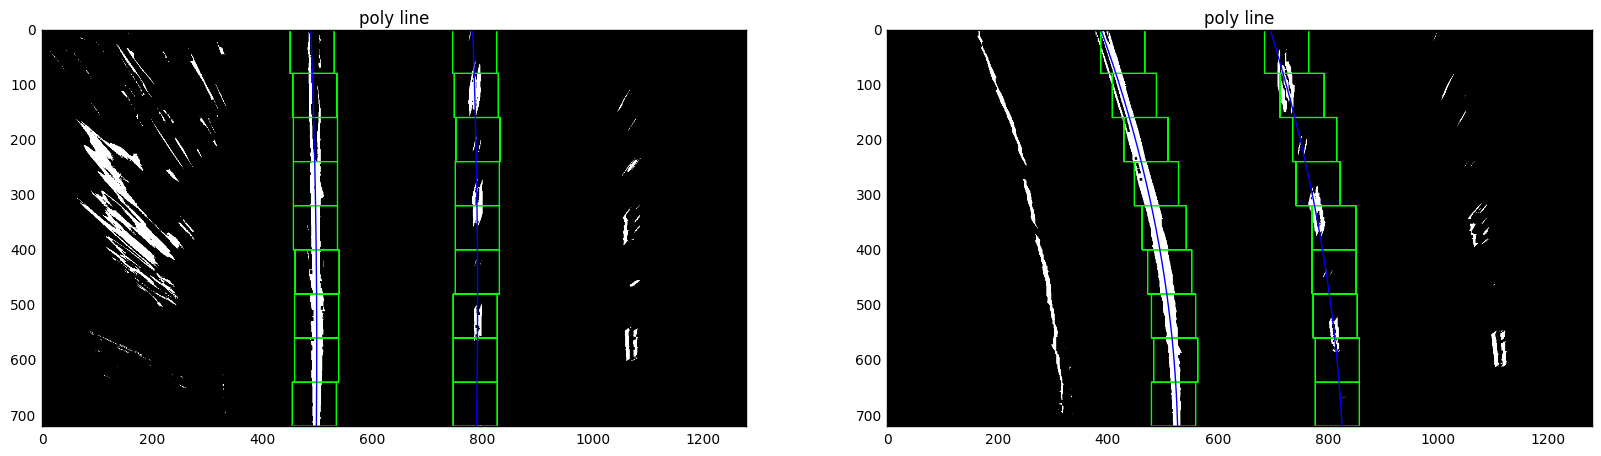

In [91]:
left_coef1 = second_order_fit(leftx1, lefty1)
right_coef1 = second_order_fit(rightx1, righty1)
left_coef2 = second_order_fit(leftx2, lefty2)
right_coef2 = second_order_fit(rightx2, righty2)
ploty1, left_fitx1, right_fitx1 = draw_poly_line(out_img1, left_coef1, right_coef1)
ploty2, left_fitx2, right_fitx2 = draw_poly_line(out_img2, left_coef2, right_coef2)

plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.title('poly line')
plt.plot(left_fitx1, ploty1, color='blue')
plt.plot(right_fitx1, ploty1, color='blue')
plt.imshow(out_img1)

plt.subplot(1,2,2)
plt.title('poly line')
plt.plot(left_fitx2, ploty2, color='blue')
plt.plot(right_fitx2, ploty2, color='blue')
plt.imshow(out_img2)

plt.show()

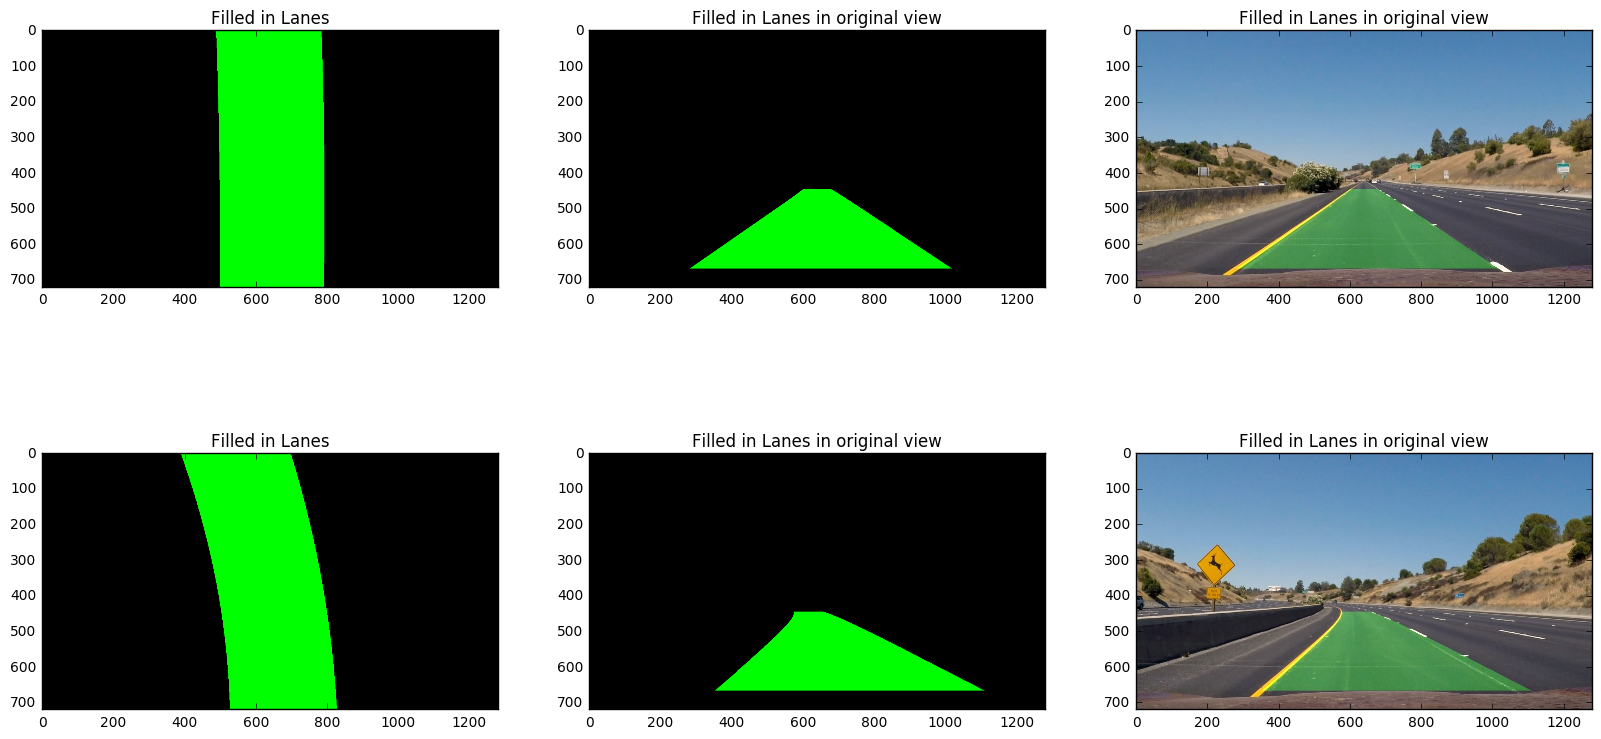

In [98]:
result1, newwarp1, color_warp1 = overlay_img(combined_binary1, ploty1, left_fitx1, right_fitx1, Minv, test_img1)
result2, newwarp2, color_warp2 = overlay_img(combined_binary2, ploty2, left_fitx2, right_fitx2, Minv, test_img2)

plt.figure(figsize = (20,10))
plt.subplot(2,3,1)
plt.title('Filled in Lanes')
plt.imshow(color_warp1)

plt.subplot(2,3,2)
plt.title('Filled in Lanes in original view')
plt.imshow(newwarp1)

plt.subplot(2,3,3)
plt.title('Filled in Lanes in original view')
plt.imshow(result1)

plt.subplot(2,3,4)
plt.title('Filled in Lanes')
plt.imshow(color_warp2)

plt.subplot(2,3,5)
plt.title('Filled in Lanes in original view')
plt.imshow(newwarp2)

plt.subplot(2,3,6)
plt.title('Filled in Lanes in original view')
plt.imshow(result2)

plt.show()

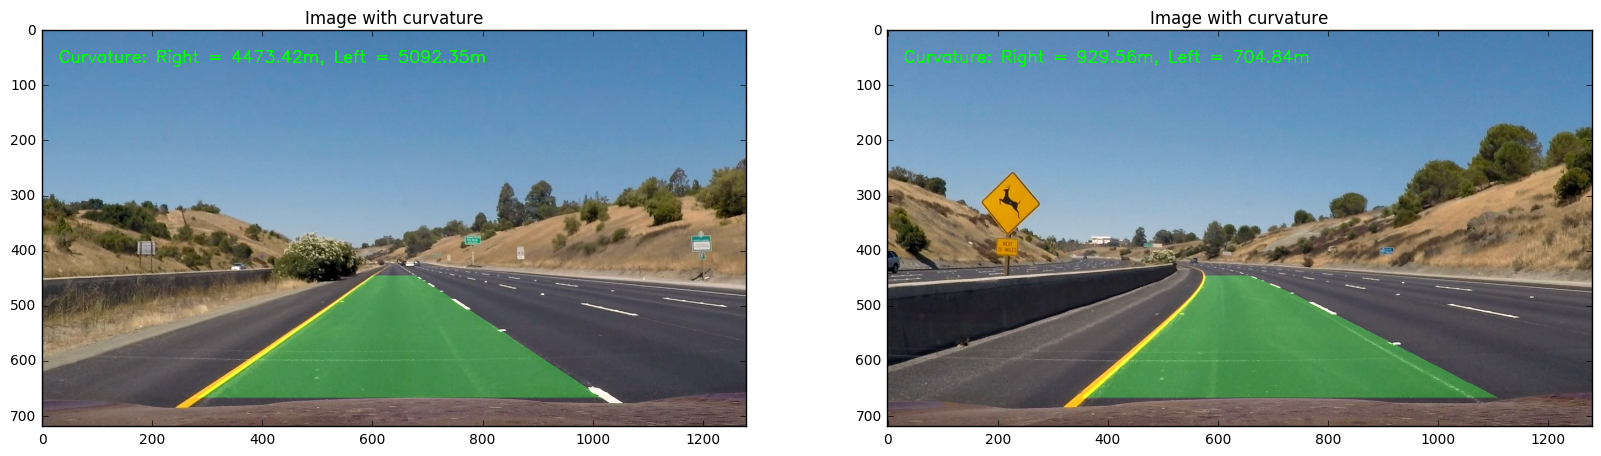

In [99]:
right_c1 = find_curvature(ploty1, rightx1, righty1)
left_c1 = find_curvature(ploty1, leftx1, lefty1)
right_c2 = find_curvature(ploty2, rightx2, righty2)
left_c2 = find_curvature(ploty2, leftx2, lefty2)

font = cv2.FONT_HERSHEY_SIMPLEX

curve_info1 = 'Curvature: Right = ' + str(np.round(right_c1,2)) + 'm' + ', Left = ' + str(np.round(left_c1,2)) +'m'
cv2.putText(result1, curve_info1, (30, 60), font, 1, (0,255,0), 2)
curve_info2 = 'Curvature: Right = ' + str(np.round(right_c2,2)) + 'm' + ', Left = ' + str(np.round(left_c2,2)) +'m'
cv2.putText(result2, curve_info2, (30, 60), font, 1, (0,255,0), 2)

plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.title('Image with curvature')
plt.imshow(result1)

plt.subplot(1,2,2)
plt.title('Image with curvature')
plt.imshow(result2)

plt.show()

In [148]:
def video_image_process(image):
    
    global pre_left_coef
    global pre_right_coef
    global pre_leftx
    global pre_lefty
    global pre_rightx
    global pre_righty
    global first_frame
    global left_error
    global right_error
    global M
    global Minv
    
    
    image = image_undistortion(image, objpoints, imgpoints)
    
    if first_frame == 1:
        M, Minv = get_transform(image)
        
    warped = bird_eye_view(image, M)
    LS_grad = LS_gradient(warped)
    color_lane = get_color_lanes(warped)
    combined_binary = comb_grad_color(color_lane, LS_grad)
    
    # take out some image noise
    kernel = np.ones((3,3),np.uint8)
    combined_binary = cv2.erode(combined_binary,kernel,iterations = 1)
    
    # set global variable with first frame
    if first_frame == 1:
        leftx, lefty, rightx, righty, out, hist = histogram_search(combined_binary)
        pre_left_coef = second_order_fit(leftx, lefty)
        pre_right_coef = second_order_fit(rightx, righty)
        pre_leftx = leftx
        pre_lefty = lefty
        pre_rightx = rightx
        pre_righty = righty
        first_frame = 0
    # redo the histogram method if there are more than 3 error   
    elif left_error > 3:
        leftx, lefty, rightx, righty, out, hist = histogram_search(combined_binary)
        left_error = 0
    elif right_error > 3:
        leftx, lefty, rightx, righty, out, hist = histogram_search(combined_binary)
        right_error = 0
    # if not use the previous lane to estimate for the next frame
    else:
        leftx, lefty, rightx, righty = next_mask(combined_binary, pre_left_coef, pre_right_coef)
    
    left_coef = second_order_fit(leftx, lefty)
    right_coef = second_order_fit(rightx, righty)
    
    # if the coef is changing too fast then use previous coef
    if abs(pre_left_coef[0]-left_coef[0]) > 0.0003:
        left_error = left_error + 1
        leftx = pre_leftx
        lefty = pre_lefty
        left_coef = pre_left_coef
    
    if abs(pre_right_coef[0]-right_coef[0]) > 0.0003:
        right_error = right_error + 1
        rightx = pre_rightx
        righty = pre_righty
        right_coef = pre_right_coef
    
    # smoothing with the last coef
    left_coef = 0.5*left_coef + 0.5*pre_left_coef
    right_coef = 0.5*right_coef + 0.5*pre_right_coef
    
    ploty, left_fitx, right_fitx = draw_poly_line(combined_binary, left_coef, right_coef)
    
    
    result, newwarp, colorwarp = overlay_img(combined_binary, ploty, left_fitx, right_fitx, Minv, image)
    right_c = find_curvature(ploty, rightx, righty)
    left_c = find_curvature(ploty, leftx, lefty)

    
    curve_info = 'Curvature: Right = ' + str(np.round(right_c,2)) + 'm' + ', Left = ' + str(np.round(left_c,2)) +'m'
    font = cv2.FONT_HERSHEY_SIMPLEX    
    cv2.putText(result, curve_info, (30, 60), font, 1, (0,255,0), 2)
    pre_leftx = leftx
    pre_lefty = lefty
    pre_rightx = rightx
    pre_righty = righty
    pre_left_coef = left_coef
    pre_right_coef = right_coef
 
    diagScreen = np.zeros((720, 1920, 3), dtype=np.uint8)
    diagScreen[0:720, 0:1280] = result
    diagScreen[0:240, 1280:1600] = cv2.resize(warped, (320,240), interpolation=cv2.INTER_AREA)
    color_lane = np.dstack((color_lane, color_lane, color_lane))
    diagScreen[240:480, 1280:1600] = cv2.resize(color_lane, (320,240), interpolation=cv2.INTER_AREA)
    LS_grad = np.dstack((LS_grad, LS_grad, LS_grad))*255
    diagScreen[480:720, 1280:1600] = cv2.resize(LS_grad, (320,240), interpolation=cv2.INTER_AREA)
    combined_binary = np.dstack((combined_binary, combined_binary, combined_binary))*255
    diagScreen[0:240, 1600:1920] = cv2.resize(combined_binary, (320,240), interpolation=cv2.INTER_AREA)
    diagScreen[240:480, 1600:1920] = cv2.resize(newwarp, (320,240), interpolation=cv2.INTER_AREA)
    diagScreen[480:720, 1600:1920] = cv2.resize(colorwarp, (320,240), interpolation=cv2.INTER_AREA)
    
    return diagScreen

In [152]:
import imageio
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [153]:
first_frame = 1
left_error = 0
right_error = 0

In [154]:
white_output = 'project_output_test.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(video_image_process)#NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_output_test.mp4
[MoviePy] Writing video project_output_test.mp4


100%|█████████▉| 1260/1261 [16:34<00:00,  1.27it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output_test.mp4 

CPU times: user 16min 34s, sys: 1min 15s, total: 17min 50s
Wall time: 16min 35s
